### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12886
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       TMAX|USC00058212|     4|[00 CF 00 D3 80 D...|1952.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       TMIN|USC00058212|    13|[A0 DB 00 7E 28 D...|1952.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       TOBS|USC00058212|     2|[40 D6 28 D8 E0 D...|1952.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0005K26S|     8|[20 D0 E0 D5 00 7...|1999.0|SSSBBBBB|
|   3340.6| 39.5667|   -105.8|       TMAX|USS0005K26S|     3|[00 46 00 D3 00 7...|2000.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
# Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00198301')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00058212')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.0  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00058212'
6 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       PRCP|USC00058212|    15|[00 00 00 00 40 4...|1900.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       PRCP|USC00058212|     2|[00 00 00 00 20 5...|1948.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(6, 365)

### Script for plotting yearly plots

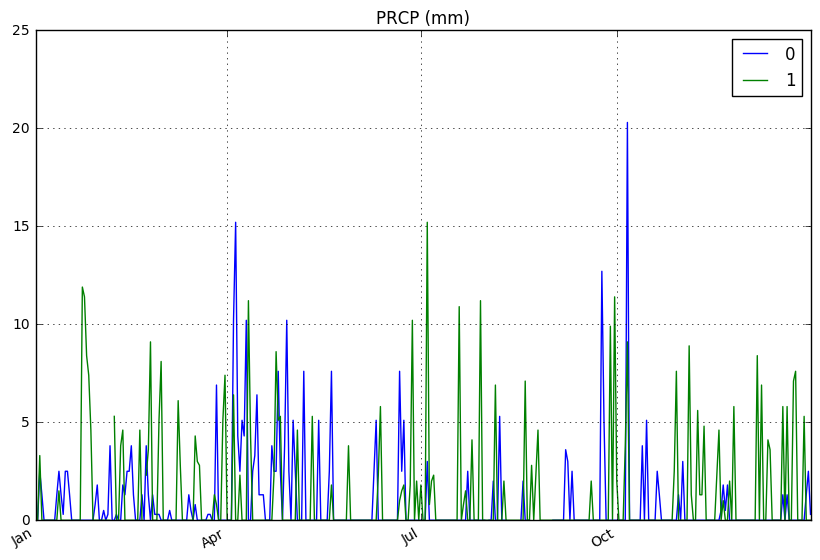

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP (mm)')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
# def plot_pair(pair,func):
#     j=0
#     fig,X=subplots(1,2,figsize=(16,6))
#     axes=X.reshape(2)
#     for m in pair:
#         axis = axes[j]
#         j+=1
#         func(m,fig,axis)

def plot_pair(pair,func,units=''):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis,units)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

TypeError: plot_valid() takes exactly 3 arguments (4 given)

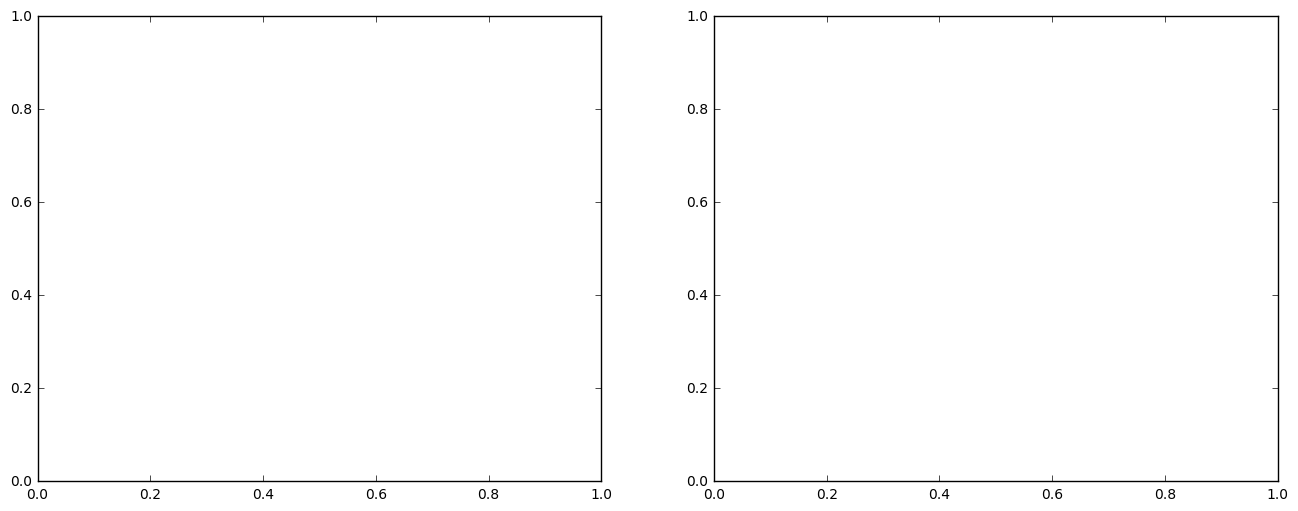

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

In [ ]:
plot_pair(['TOBS','PRCP'],plot_valid)

In [ ]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [7]:
# def plot_mean_std(m,fig,axis):
#     mean=STAT[m]['Mean']
#     std=np.sqrt(STAT[m]['Var'])
#     graphs=np.vstack([mean-std,mean,mean+std]).transpose()
#     YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

def plot_mean_std(m,fig, axis, units = ''):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m + units)

In [ ]:
plot_pair(['TMIN','TMAX'],plot_mean_std,' (Tenths Degrees Centigrade)')

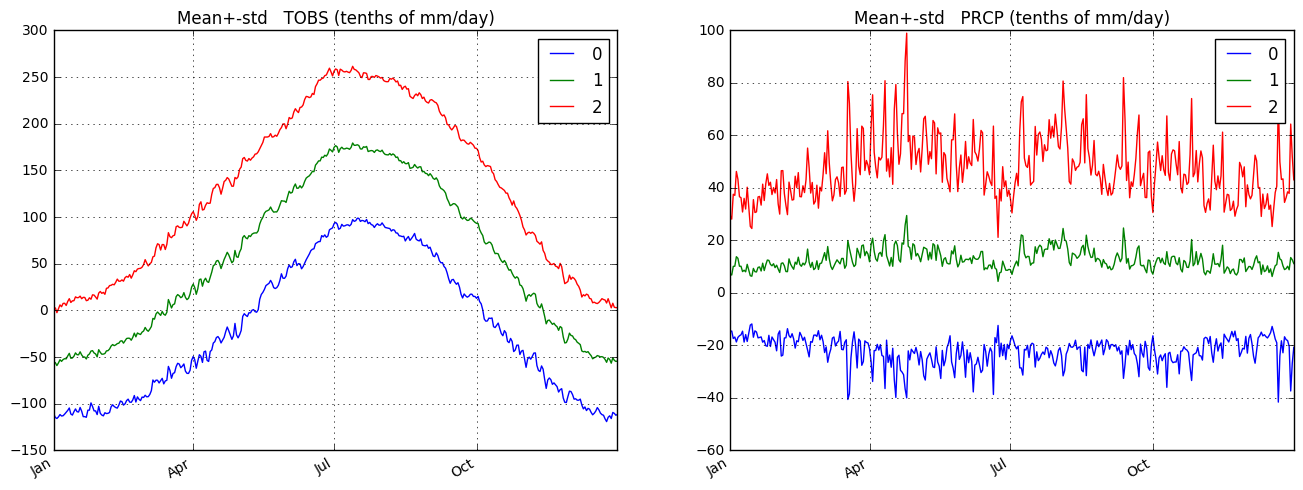

In [8]:
plot_pair(['TOBS','PRCP'],plot_mean_std, ' (tenths of mm/day)')

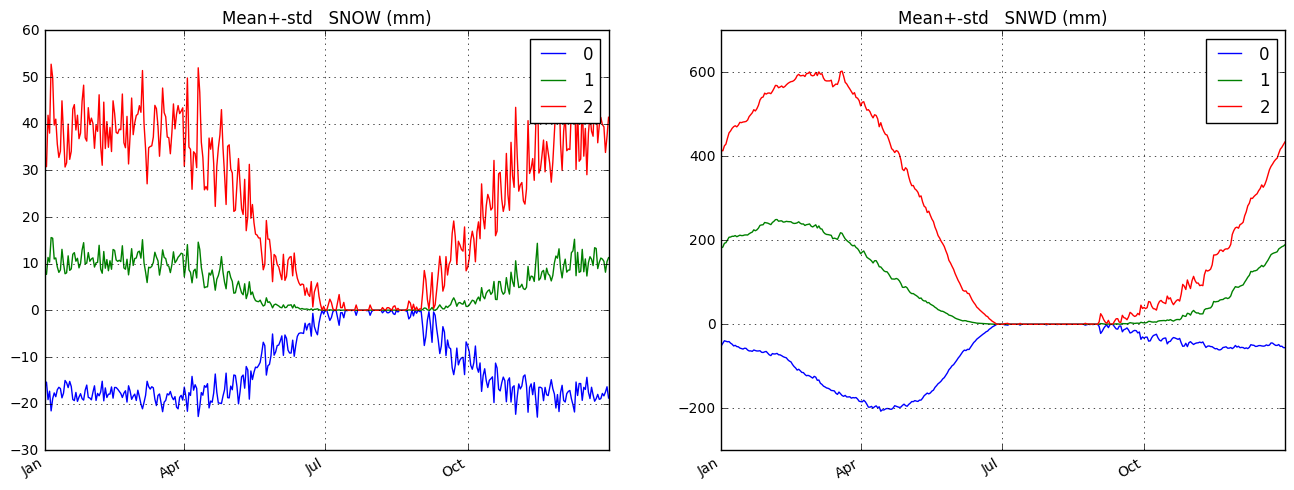

In [52]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std, ' (mm)')

### plotting top 3 eigenvectors

In [55]:
# def plot_eigen(m,fig,axis):
#     EV=STAT[m]['eigvec']
#     YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

def plot_eigen(m,fig,axis, units = ''):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m + units)

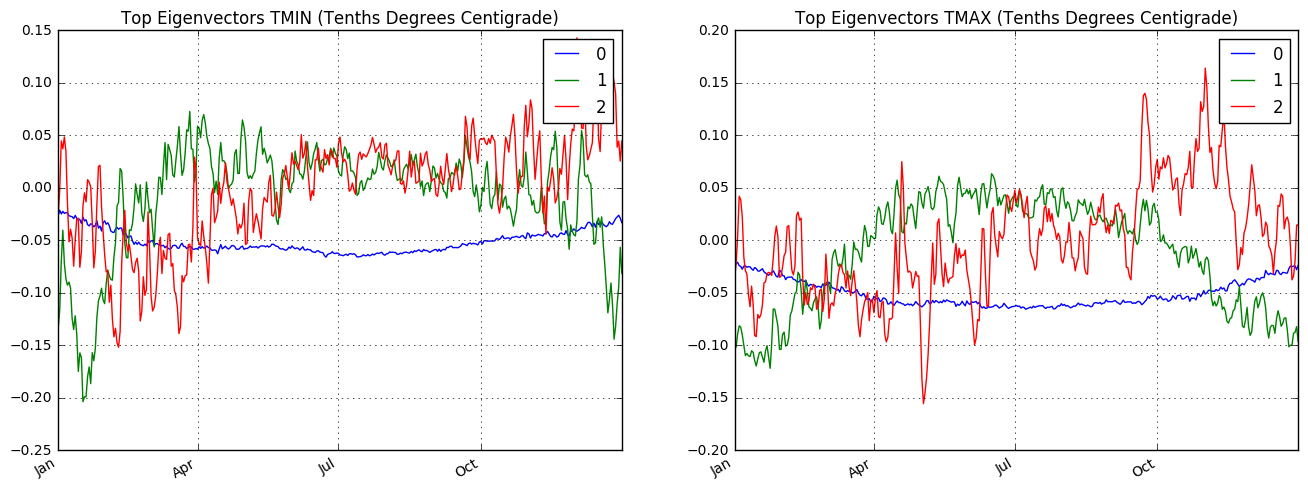

In [57]:
plot_pair(['TMIN','TMAX'],plot_eigen, ' (Tenths Degrees Centigrade)')

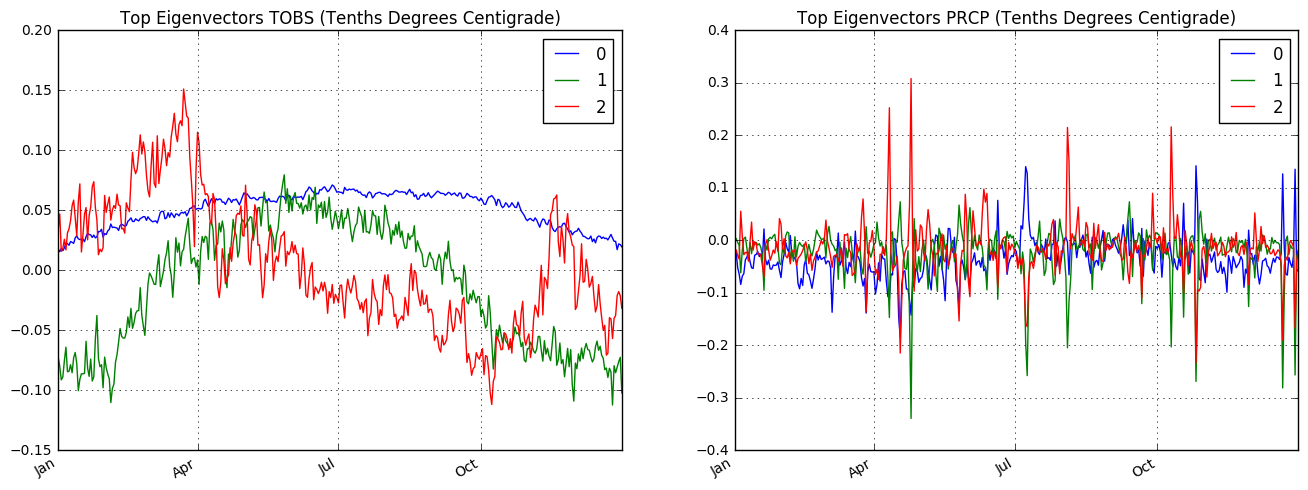

In [58]:
plot_pair(['TOBS','PRCP'],plot_eigen, ' (Tenths Degrees Centigrade)')

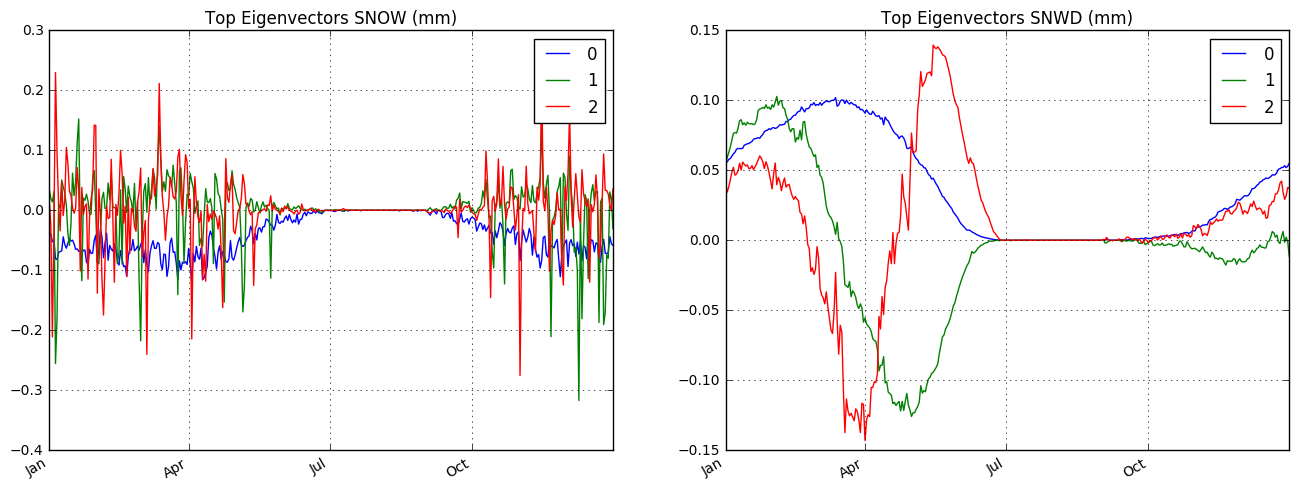

In [59]:
plot_pair(['SNOW', 'SNWD'],plot_eigen ,' (mm)')

### Script for plotting percentage of variance explained

In [16]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

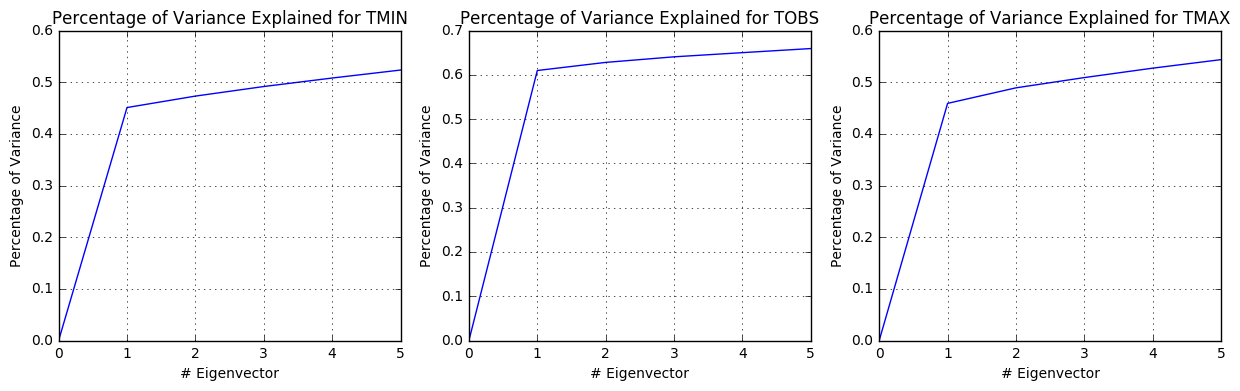

In [17]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

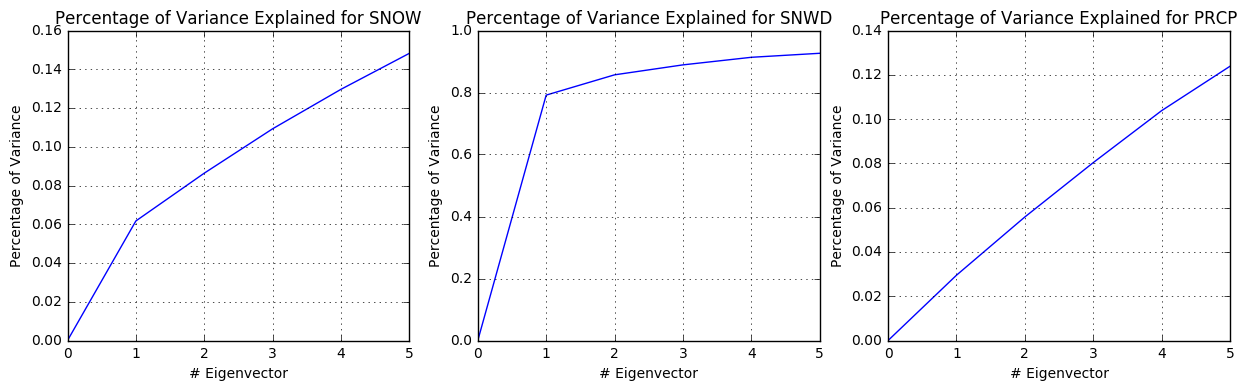

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()